# 20기 Clustering 정규세션 과제

- 제출자: 20기 황태연
- 제출 일자: 2023.08.15. (화)

**데이터:** [Mall Customer Segmentation Data| Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

# 0. 데이터 불러오기

In [2]:
import pandas as pd
df = pd.read_csv("Mall_Customers.csv", index_col = 0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


# 1. Preprocssing / EDA

## 1.1. 데이터 확인하기

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


- 모든 데이터가 유효하며, 결측치는 없습니다.

In [4]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


- z 점수의 절댓값이 3 이상인 이상치가 Annual Income에 존재하는 것으로 보이지만, 데이터 수가 적기 때문에 따로 이상치 제거 과정을 거치지 않겠습니다.
- 그러나 Age, Annual Income, Spending Score 사이의 평균, 표준편차가 다르므로 normalization을 진행할 필요가 있습니다.

In [7]:
df['Gender'].value_counts()

Female    112
Male       88
Name: Gender, dtype: int64

## 1.2. 전처리

- Standard Normalization을 진행합니다.

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(['Gender'], axis=1))
df_scaled = pd.DataFrame(scaled, columns=['Age', 'Annual_Income', 'Spending_Score'])
df_scaled

,Age,Annual_Income,Spending_Score
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980
...,...,...,...
195,-0.276302,2.268791,1.118061
196,0.441365,2.497807,-0.861839
197,-0.491602,2.497807,0.923953
198,-0.491602,2.917671,-1.250054


- Gender는 원 핫 인코딩을 진행한 후, **다중공선성**문제를 해결하기 위해 두 변수 중 하나만을 택하여 남깁니다.

In [33]:
df_encoded = pd.get_dummies(df['Gender'])
df_encoded = df_encoded.reset_index() # CustomerID라는 index를 새로운 열로 추가하고, 새로운 정수 인덱스를 부여한다.
df_final = pd.concat([df_encoded, df_scaled], axis=1)
df_final = df_final.drop(['CustomerID', 'Female'], axis=1)
df_final

,Male,Age,Annual_Income,Spending_Score
0,1,-1.424569,-1.738999,-0.434801
1,1,-1.281035,-1.738999,1.195704
2,0,-1.352802,-1.700830,-1.715913
3,0,-1.137502,-1.700830,1.040418
4,0,-0.563369,-1.662660,-0.395980
...,...,...,...,...
195,0,-0.276302,2.268791,1.118061
196,0,0.441365,2.497807,-0.861839
197,1,-0.491602,2.497807,0.923953
198,1,-0.491602,2.917671,-1.250054


- 이렇게 모든 데이터의 전처리를 완료했습니다.

## 1.3. EDA

- 어떤 변수들로 Clustering을 진행할지 결정하기 위해서 변수간의 관계를 살펴볼 필요가 있습니다.

- seaborn 라이브러리의 pairplot은 각 변수의 상관관계를 산점도로 확인할 수 있습니다.

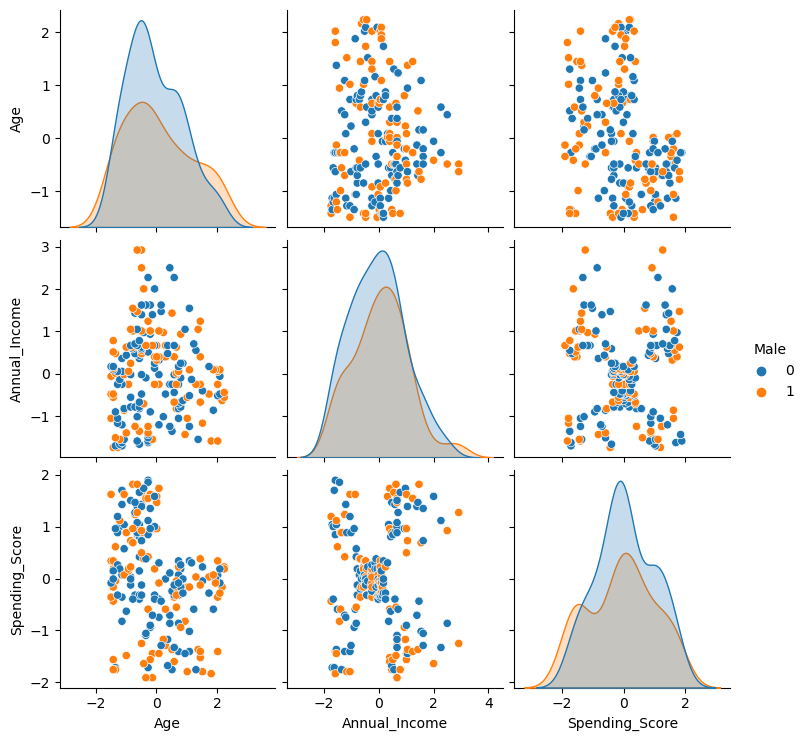

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_final, hue='Male')
plt.show()

- 직관적으로 그룹을 나누어 분류할 수 있는 변수는 Annual_Income과 Spending_Score입니다.
    - 그룹은 좌측 상단, 우측 상단, 중앙, 좌측 하단, 우측 하단 총 5개로 분류 가능합니다.
- 이 두 변수를 중점적으로 Clustering을 진행하겠습니다.

In [49]:
df = df_final[['Annual_Income', 'Spending_Score']]

# 2. Clustering

## 2.1. Hierarchical Clustering

- **Hierarchical Clustering(계층적 군집화)**: 데이터를 계층적 구조로 분류하는 군집화 방법
    - **Agglomerative Clustering(병합 군집)**: 가장 가까운 데이터부터 차례대로 묶어나가는 계층적 군집화 방법
    - **Divisive Clustering(분할 군집)**: 주어진 데이터를 한 집단으로 보고 점차 집단을 분할하는 방식으로 분류하는 계층적 군집화 방법

**Agglomerative Clustering(병합 군집)**

- sklearn 라이브러리의 AgglomerativeClustering을 이용하여 계층 군집화를 할 수 있습니다.

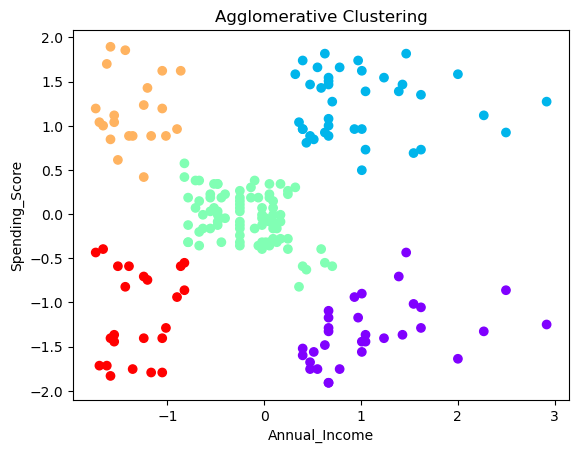

In [72]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=5, linkage='ward')
cluster_agg = agg.fit_predict(df)

plt.scatter(df['Annual_Income'], df['Spending_Score'], c=cluster_agg, cmap='rainbow')
plt.xlabel('Annual_Income')
plt.ylabel('Spending_Score')
plt.title('Agglomerative Clustering')
plt.show()

- 클러스터링이 어느 정도 잘 이루어진 모습을 볼 수 있습니다. 다만, 좌측 하단과 중앙 사이에 다소 분류가 불분명한 것처럼 보입니다.

- 아래는 덴드로그램을 이용하여 군집화 과정을 시각화한 것입니다.

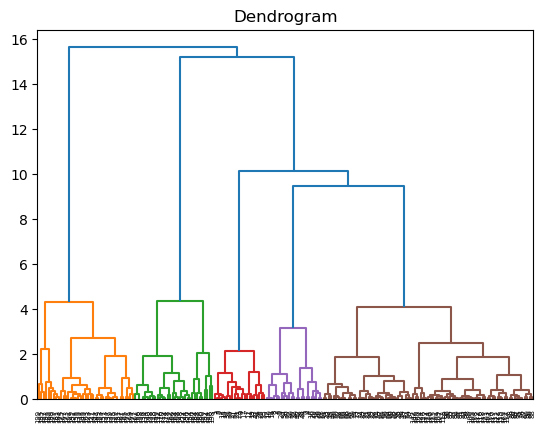

In [67]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(df, method='ward')

dendrogram(linkage_matrix, color_threshold = 8) # color_threshold를 조절하여 그룹을 적절히 색으로 나눌 수 있다.
plt.title('Dendrogram')
plt.show()

- Divisive Clustering도 위와 매우 유사한 방법으로 구현할 수 있습니다.

## 2.2. Partitioning Clustering

- **Partitioning Clustering(분리형 군집화)**: 전체 데이터를 특정 기준에 의해 동시에 구분해주는 군집화
    - **K-means**: 군집 개수를 미리 정한 뒤 중심을 설정하고 데이터를 할당하는 과정을 반복하는 분리형 군집화 방법
    - **DBSCAN(Densdity-Based Spatial Clustering of Applications with Noise)**: 군집 개수를 미리 지정하지 않고, 데이터의 밀도를 기반으로 분류하는 분리형 군집화 방법

**K-means**

- sklearn 라이브러리의 KMeans를 이용하여 K-Means 클러스터링을 진행할 수 있습니다.

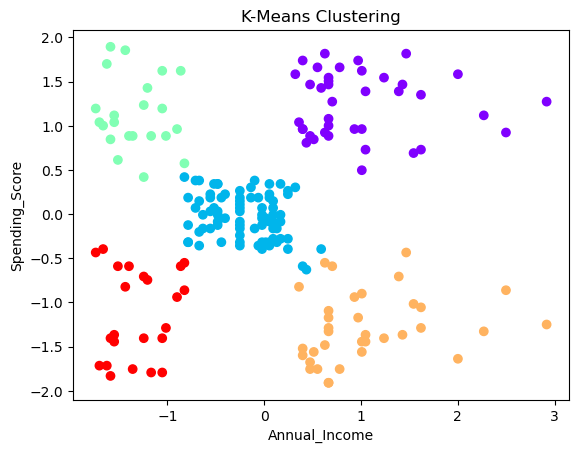

In [78]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=5)
cluster_km = km.fit_predict(df)

plt.scatter(df['Annual_Income'], df['Spending_Score'], c=cluster_km, cmap='rainbow')
plt.xlabel('Annual_Income')
plt.ylabel('Spending_Score')
plt.title('K-Means Clustering')
plt.show()

- 직관적으로 예상했던 그룹의 분류와 거의 일치하게 클러스터링된 모습을 확인할 수 있다.

**DBSCAN**

- sklearn 라이브러리의 DBSCAN를 이용하여 DBSCAN 클러스터링을 진행할 수 있습니다.

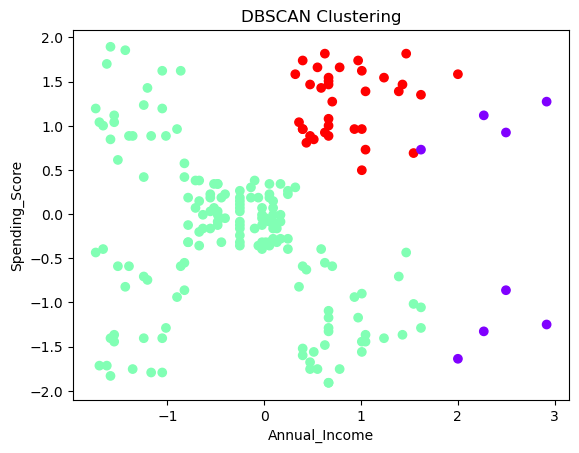

In [79]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.5, min_samples=5)
    # eps: 클러스터를 구성하는 최소 거리
    # min_samples: 클러스터 구성 시 필요한 최소 데이터 포인터 수
cluster_db = db.fit_predict(df)

plt.scatter(df['Annual_Income'], df['Spending_Score'], c=cluster_db, cmap='rainbow')
plt.xlabel('Annual_Income')
plt.ylabel('Spending_Score')
plt.title('DBSCAN Clustering')
plt.show()

- DBSCAN은 클러스터링이 잘 이루어지지 않은 모습을 확인할 수 있다.

# 3. Evaluation

- **실루엣(Silhouette)**: 클러스터링이 잘 되었는지를 펼가하는 지표 중 하나. 클러스터 내의 거리와 클러스터 간의 거리를 이용하여 측정하며, -1에 가까우면 성능이 낮고, 1에 가까우면 성능이 높다고 볼 수 있다.
$$
Silhouette = \frac{1}{n}\sum_{i=1}^{n}S(i) \\
S(i) = \frac{b(i)-a(i)}{\max \{a(i), b(i)\}}
$$
($a(i)$: 개체 $i$로부터 같은 군집 내에 있는 모든 개체들 사이의 평균 거리, $b(i)$: 개체 $i$로부터 다른 군집 내에 있는 개체들 사이의 평균 거리 중 가장 작은 값)

- sklearn에서는 실루엣 스코어를 계산해주는 함수를 제공하고 있습니다.
- 이 함수를 이용하여 위의 3개의 클러스터링의 실루엣 점수를 비교해보겠습니다.

In [83]:
from sklearn.metrics import silhouette_score

silhouette_agg = silhouette_score(df, cluster_agg)
silhouette_km = silhouette_score(df, cluster_km)
silhouette_db = silhouette_score(df, cluster_db)

print('Agglomerative Clustering:', silhouette_agg)
print('K-Means:', silhouette_km)
print('DBSCAN:', silhouette_db)

Agglomerative Clustering: 0.5538089226688662
K-Means: 0.5546571631111091
DBSCAN: 0.35044619989666004


- 위 평가지표를 통해 K-Means가 클러스터링을 가장 잘 수행했음을 알 수 있습니다.